<a href="https://colab.research.google.com/github/Dikshuy/hail_UMICaana/blob/master/Achintya_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import os
from google.colab import drive
from google.colab.patches import cv2_imshow
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, ZeroPadding2D, BatchNormalization, Add
from keras.models import Model
from tensorflow.keras.losses import MAE
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation
from keras import backend as K 
from keras import regularizers
from keras.initializers import glorot_uniform
from sklearn.utils import shuffle
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Letters'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Letters


In [ ]:
pixel = 64
symbols = []
alphabets = []


img_path = '/content/drive/My Drive/Letters'
for file in os.listdir('/content/drive/My Drive/Letters'):
  img = cv2.imread(os.path.join(img_path, file))
  img = cv2.resize(img, (pixel, pixel))
  alpha = 1
  beta = 50
  for i in range(-3, 2):
    new_img = np.zeros(img.shape, img.dtype)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img[y,x,c] = np.clip(alpha*img[y,x,c] + beta*i, 0, 255)
    symbols.append(new_img)
  alphabets.append(file[0])

print(alphabets)
print(len(symbols))


['P', 'S', 'L', 'U', 'B', 'O', 'G', 'N', 'C', 'Y', 'K', 'C', 'M', 'F', 'I', 'H', 'A', 'T']
90


In [ ]:
one_hot = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

data = []
label = []

for j in range(len(symbols)):
    symbols[j] = cv2.cvtColor(symbols[j], cv2.COLOR_BGR2GRAY)
    data.append(symbols[j])

for j in range(len(alphabets)):
  for i in range(-3, 2):
    label.append(one_hot[j])

print(len(label), len(data), len(symbols))

for j in range(len(symbols)):
  for i in range(-3, 4):
    rows, cols = data[j].shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 5*i, 1)
    res = cv2.warpAffine(data[j], M, (rows, cols))
    label.append(label[j])
    data.append(res)

for i in range(len(data)):
  data[i] = cv2.resize(data[i], (pixel, pixel))
 
print(len(label), len(data))
num = len(label)

"""for j in range(num):
  height, width = data[j].shape[:2]

  dis_y, dis_x = height//10, width//10
  T = np.float32([[1, 0, dis_x], [0, 1, dis_y]])

  img_trans = cv2.warpAffine(data[j], T, ( width, height))
  data.append(img_trans)
  label.append(label[j])

  T = np.float32([[1, 0, -dis_x], [0, 1, -dis_y]])

  img_trans = cv2.warpAffine(data[j], T, ( width, height))
  data.append(img_trans)
  label.append(label[j])"""


90 90 90
720 720


'for j in range(num):\n  height, width = data[j].shape[:2]\n\n  dis_y, dis_x = height//10, width//10\n  T = np.float32([[1, 0, dis_x], [0, 1, dis_y]])\n\n  img_trans = cv2.warpAffine(data[j], T, ( width, height))\n  data.append(img_trans)\n  label.append(label[j])\n\n  T = np.float32([[1, 0, -dis_x], [0, 1, -dis_y]])\n\n  img_trans = cv2.warpAffine(data[j], T, ( width, height))\n  data.append(img_trans)\n  label.append(label[j])'

In [ ]:
for j in range(num):
  res_img = cv2.GaussianBlur(data[j], (3, 3), 0)
  data.append(res_img)
  label.append(label[j])


for j in range(num):
  res_img = cv2.medianBlur(data[j], 5)
  data.append(res_img)
  label.append(label[j])


for j in range(num):
  res_img = cv2.bilateralFilter(data[j], 11, 200, 200)
  data.append(res_img)
  label.append(label[j])

"""for j in range(num):
  res_img = cv2.erode(data[j], np.ones((3,3)), iterations = 1)
  data.append(res_img)
  label.append(label[j])

for j in range(num):
  res_img = cv2.dilate(data[j], np.ones((1, 1), np.uint8), iterations = 1)
  data.append(res_img)
  label.append(label[j])
"""

images = np.array(data).reshape(-1, pixel, pixel, 1)
print(images.shape)
y = np.array(label)
print(y.shape)


(2880, 64, 64, 1)
(2880, 18)


[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
['P', 'S', 'L', 'U', 'B', 'O', 'G', 'N', 'C', 'Y', 'K', 'C', 'M', 'F', 'I', 'H', 'A', 'T']


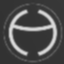

F


In [ ]:
no = 789
print(y[no])
print(alphabets)
cv2_imshow(images[no].reshape(64, 64, 1))
print(alphabets[np.argmax(label[no])])

In [ ]:
def res_identity(x, filters, gamma = 0.0001):
  x_skip = x
  f1, f2 = filters
  
  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(gamma))(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(gamma))(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(gamma))(x)
  x = BatchNormalization()(x)
  #x = Activation('tanh')(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation('tanh')(x)

  return x

In [ ]:
def res_conv(x, s, filters, gamma = 0.0001):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=regularizers.l2(gamma))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(gamma))(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(gamma))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=regularizers.l2(gamma))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation('tanh')(x)

  return x

In [ ]:
def resnet50(input_shape = (pixel, pixel, 1), classes = len(alphabets)):

  input_im = Input(input_shape) 
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(5, 5), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(alphabets), activation='softmax', kernel_initializer='he_normal')(x)

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [ ]:
model = resnet50()
batch_size = 100

opt = tf.keras.optimizers.SGD(learning_rate=0.5)
opt1 = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy'])

#images, y = shuffle(images, y, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2)

#X_train = X_train/255.0
#X_test = X_test/255.0

history = model.fit(X_train, y_train, epochs= 200, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/200
24/24 [==============================] - 9s 381ms/step - loss: 3.9987 - accuracy: 0.4180 - val_loss: 4.2595 - val_accuracy: 0.3368
Epoch 2/200
24/24 [==============================] - 6s 266ms/step - loss: 2.5582 - accuracy: 0.8720 - val_loss: 3.3708 - val_accuracy: 0.6806
Epoch 3/200
24/24 [==============================] - 6s 265ms/step - loss: 2.0638 - accuracy: 0.9614 - val_loss: 2.7073 - val_accuracy: 0.8368
Epoch 4/200
24/24 [==============================] - 6s 264ms/step - loss: 1.9085 - accuracy: 0.9896 - val_loss: 2.2819 - val_accuracy: 0.9323
Epoch 5/200
24/24 [==============================] - 6s 262ms/step - loss: 1.8957 - accuracy: 0.9865 - val_loss: 2.1198 - val_accuracy: 0.9392
Epoch 6/200
24/24 [==============================] - 6s 263ms/step - loss: 1.8734 - accuracy: 0.9931 - val_loss: 2.0136 - val_accuracy: 0.9566
Epoch 7/200
24/24 [==============================] - 6s 263ms/step - loss: 1.8503 - accuracy: 0.9948 - val_loss: 1.9325 - val_accuracy: 0.9705

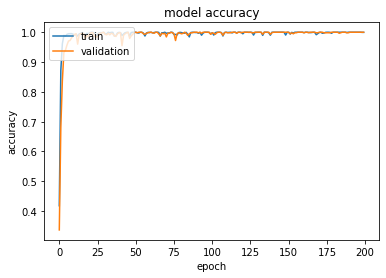

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='bottom right')
plt.show()

In [ ]:
test = []
n = 0
t = 0
img_path = '/content/drive/My Drive/A'
for file in os.listdir(img_path):
  img = cv2.imread(os.path.join(img_path, file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (pixel, pixel))
  alpha = 1.3
  beta = 25
  new_img = np.zeros(img.shape, img.dtype)
  for y in range(img.shape[0]):
      for x in range(img.shape[1]):
        new_img[y,x] = np.clip(alpha*img[y,x] + beta, 0, 255)
  img = np.array(new_img).reshape(1, pixel, pixel, 1)
  predictions = model.predict(img)
  t+=1
  x = alphabets[np.argmax(predictions[0])]
  print(max(predictions[0]))
  if max(predictions[0]) < 0.5:
    cv2_imshow(img.reshape(pixel, pixel, 1))
  if x != 'A':
    print(alphabets[np.argmax(predictions)])
    print("2", max(predictions[0]))
    cv2_imshow(img.reshape(pixel, pixel, 1))
    n+=1

print(n)
print(t)

0.99999654
0.9999988
0.9999958
0.99999905
0.999992
0.99999714
0.99999523
0.9999982
0.99999905
0.9999949
0.99999917
0.9999918
0.9999956
0.9999937
0.99997103
0.999998
0.9999963
0.999998
0.9999981
0.99998045
0.99999666
0.99999166
0.99999535
0.99999845
0.99999344
0.9988115
0.99994946
0.99996006
0.9999211
0.99998724
0.9999945
0.99999905
0.9999833
0.99999833
0.9999976
0.9999968
0.9997944
0.999995
0.99999666
0.999992
0.9999968
0.99996376
0.9999958
0.9999982
0.99999785
0.99999297
0.9999995
0.9999962
0.9999784
0.9999968
0.9999982
0.999998
0
52


0.44443357
I
2 0.44443357


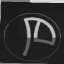

0.9996613
0.9986083
0.9996408
0.99991643
0.99240583
0.9995932
0.9991159
0.9999851
0.99966776
0.9999963
0.99404484
0.9992519
0.99961543
0.8474421
0.95198023
0.9998739
0.99965584
0.9963966
0.9999893
0.9686363
0.9885598
0.9998646
0.999967
0.99998486
0.99998105
0.9999225
0.9999864
0.99996006
0.99985874
0.99993694
0.99893564
0.9957283
0.99783474
0.99968636
0.998216
0.9699238
0.9999496
0.96813536
0.85309035
0.7816358
0.6590177
C
2 0.6590177


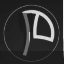

0.9832388
0.9971916
0.864115
0.96658874
0.9635704
0.7152421
0.50094205
0.75531906
C
2 0.75531906


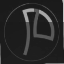

0.9935034
0.9608263
P
2 0.9608263


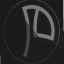

0.98401225
0.90362006
0.576834
P
2 0.576834


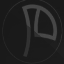

0.9987184
P
2 0.9987184


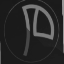

0.69524395
P
2 0.69524395


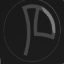

0.93055964
P
2 0.93055964


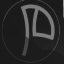

0.98862094
0.95904136
0.99209964
P
2 0.99209964


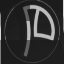

0.9917768
0.99000883
P
2 0.99000883


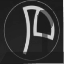

0.8767497
0.9244119
P
2 0.9244119


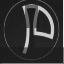

0.96145785
P
2 0.96145785


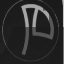

0.42069116
P
2 0.42069116


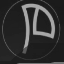

0.47146356
0.996912
0.9995788
0.98092973
0.9997029
0.99836975
0.99989665
0.997717
0.9989942
0.99968433
0.9991105
0.9995586
0.96266204
0.9996201
0.99954224
0.9998388
0.99967015
0.99651307
0.99827385
0.9999535
0.99994075
0.999423
0.9995271
0.9999794
13
91


In [ ]:
n = 0
t = 0
img_path = '/content/drive/My Drive/B'
for file in os.listdir(img_path):
  img = cv2.imread(os.path.join(img_path, file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (pixel, pixel))
  alpha = 1.3
  beta = 25
  new_img = np.zeros(img.shape, img.dtype)
  for y in range(img.shape[0]):
      for x in range(img.shape[1]):
        new_img[y,x] = np.clip(alpha*img[y,x] + beta, 0, 255)
  img = np.array(new_img).reshape(1, pixel, pixel, 1)
  predictions = model.predict(img)
  t+=1
  x = alphabets[np.argmax(predictions[0])]
  print(max(predictions[0]))
  if x != 'B':
    print(alphabets[np.argmax(predictions)])
    print("2", max(predictions[0]))
    cv2_imshow(img.reshape(pixel, pixel, 1))
    n+=1

print(n)
print(t)

0.99969244
0.9997613
0.9970739
0.99841833
0.90676516
0.9738264
0.91563237
C
2 0.91563237


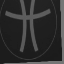

0.5762894
B
2 0.5762894


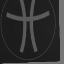

0.99990773
0.99996483
0.99977356
0.9992848
0.9993674
0.9991399
0.9996043
0.9986279
0.999316
0.9999542
0.9993832
0.9995572
0.9999701
0.99963784
0.99913967
0.998447
0.99995446
2
25


In [ ]:

n = 0
t = 0
img_path = '/content/drive/My Drive/Y'
for file in os.listdir(img_path):
  img = cv2.imread(os.path.join(img_path, file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (pixel, pixel))
  alpha = 1.3
  beta = 25
  new_img = np.zeros(img.shape, img.dtype)
  for y in range(img.shape[0]):
      for x in range(img.shape[1]):
        new_img[y,x] = np.clip(alpha*img[y,x] + beta, 0, 255)
  img = np.array(new_img).reshape(1, pixel, pixel, 1)
  predictions = model.predict(img)
  t+=1
  x = alphabets[np.argmax(predictions[0])]
  print(max(predictions[0]))
  if x != 'Y':
    print(alphabets[np.argmax(predictions)])
    print("2", max(predictions[0]))
    cv2_imshow(img.reshape(pixel, pixel, 1))
    n+=1

print(n)
print(t)

0.9999931
0.9735141
0.99979514
0.9546506
0.8624647
0.999987
0.9999943
0.9985934
0.99645954
0.999969
0.99935144
0.99941134
0.9999653
0.9999826
0.9636444
U
2 0.9636444


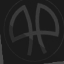

0.7930684
0.9998634
0.99976784
0.9662052
0.5267323
P
2 0.5267323


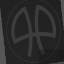

0.98553365
0.7482927
P
2 0.7482927


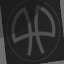

0.99659866
0.8955009
U
2 0.8955009


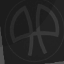

0.9999739
0.99994326
0.85084075
0.6519628
0.93603444
U
2 0.93603444


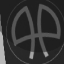

0.99894506
0.88128036
0.28742534
0.72387725
Y
2 0.72387725


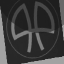

0.9750543
0.6010299
Y
2 0.6010299


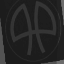

0.5433387
0.9999255
0.95630753
I
2 0.95630753


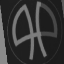

0.63653326
Y
2 0.63653326


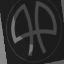

0.43152386
I
2 0.43152386


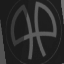

0.9068977
0.6760069
U
2 0.6760069


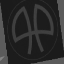

0.999785
0.9738144
0.9997068
0.9761796
I
2 0.9761796


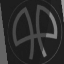

0.7371884
0.99893385
0.9995141
12
49


In [ ]:

n = 0
t = 0
img_path = '/content/drive/My Drive/C'
for file in os.listdir(img_path):
  img = cv2.imread(os.path.join(img_path, file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (pixel, pixel))
  alpha = 1.3
  beta = 25
  new_img = np.zeros(img.shape, img.dtype)
  for y in range(img.shape[0]):
      for x in range(img.shape[1]):
        new_img[y,x] = np.clip(alpha*img[y,x] + beta, 0, 255)
  img = np.array(new_img).reshape(1, pixel, pixel, 1)
  predictions = model.predict(img)
  t+=1
  x = alphabets[np.argmax(predictions[0])]
  print(max(predictions[0]))
  if x != 'C':
    print(alphabets[np.argmax(predictions)])
    print("2", max(predictions[0]))
    cv2_imshow(img.reshape(pixel, pixel, 1))
    n+=1

print(n)
print(t)

In [ ]:
n = 0
t = 0
img_path = '/content/drive/My Drive/Letters/F.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (pixel, pixel))
img = np.array(img).reshape(1, pixel, pixel, 1)
predictions = model.predict(img)
print(alphabets[np.argmax(predictions[0])])
print(max(predictions[0]))
print(alphabets)

F
0.9999217
['P', 'S', 'L', 'U', 'B', 'O', 'G', 'N', 'C', 'Y', 'K', 'C', 'M', 'F', 'I', 'H', 'A', 'T']


In [ ]:
alphabets = ['P', 'S', 'L', 'U', 'B', 'O', 'G', 'N', 'C', 'Y', 'K', 'C', 'M', 'F', 'I', 'H', 'A', 'T']
img_path = '/content/drive/My Drive/Mixed/w8.png'
img = cv2.imread(img_path)
im2 = img.copy()
alpha = 1.4
beta = 50
new_img = np.zeros(img.shape, img.dtype)
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
      new_img[y,x] = np.clip(alpha*img[y,x] + beta, 0, 255)

gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
dilation = cv2.dilate(thresh, rect_kernel, iterations = 5)
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  if h<100 and w<100:
    continue
  rect = cv2.rectangle(im2, x, y, x+w, y+h)
  cropped = im2[y:y+h, x:x+w]
  cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
  #cv2_imshow(cropped)
  cropped = cv2.resize(cropped, (128, 64))
  imgs = np.array(cropped).reshape(64, 128)
  img1 = imgs[:, :64]
  img2 = imgs[:, 64:]

  img1 = img1.reshape(1, 64, 64, 1)
  img2 = img2.reshape(1, 64, 64, 1)

  #cv2_imshow(img1.reshape(64, 64))
  #cv2_imshow(img2.reshape(64, 64))

  pred1 = model.predict(img1)
  pred2 = model.predict(img2)

  print(alphabets[np.argmax(pred1[0])])
  print(alphabets[np.argmax(pred2[0])])


T
L
